### Collecting data and processing data funcs:
Run this cell (select, then shift+enter)

In [1]:
#@title
from matplotlib import pyplot as plt
from pandas import json_normalize
import json
import pandas as pd
from tqdm import tqdm
import requests
import time
import seaborn as sns

sns.set_style("whitegrid")


def make_deep_requests(url, depth=5, limit=1000, sleep_time=2, stop_id=None):

    last_id = None
    data = pd.DataFrame()

    for counter in tqdm(range(depth)):
        if last_id:
            url += f'&lastId={last_id}'

        try:
            response = requests.get(url)
            new_data = json_normalize(json.loads(response.text))
            data = data.append(new_data)

        except Exception as exception:
            print(exception)
            import pdb; pdb.set_trace()

        last_id = data.id.iloc[-1]

        if len(new_data) < limit:
            break

        if stop_id in data['id'].values:
            break

        time.sleep(sleep_time)

    return data


def process_pool_data(df, token_decimals=6):

    convert = {
        'value.storage.tez_pool': lambda x: float(x) / 1_000_000,
        'value.storage.token_pool': lambda x: float(x) / (10**token_decimals),
        'timestamp': pd.Timestamp
    }

    for column_name, mapper in convert.items():
        df[column_name] = df[column_name].map(mapper)

    df['rate'] = df['value.storage.tez_pool'] / df['value.storage.token_pool']
    df = df.set_index('timestamp')
    return df


def collect_storage_history(smart_contract, depth=1):
    url = f'https://api.tzkt.io/v1/contracts/{smart_contract}/storage/history?limit=1000'
    return make_deep_requests(url, depth=depth)

### Requesting data:

In [2]:
# Insert here another QuipuSwap v1.2 contracts if you want to:
tokens = dict(
    hDAO = 'KT1QxLqukyfohPV5kPkw97Rs6cw1DDDvYgbB',  # 6 decimals
    WRAP = 'KT1FG63hhFtMEEEtmBSX2vuFmP87t9E7Ab4t',  # 8 decimals
    tCow = 'KT1XQZxsG4pMgcN7q7Nu3XFihsb9mEvqBmAT',
    bDAO = 'KT1DssMzoSr8fnUUq1WxeSuHfLG4gzS7pgge',
    sDAO = 'KT1WDe2vJCDqz5euKupppQsioPcakUd45Tfo'
)

# Select one contract from the above dictionary:
token = 'WRAP'
contract_address = tokens[token]

# Change token decimals if necessary (hDAO is 6, WRAP is 8):
token_decimals = 8

# Set requests depth if there are needed more than one request to pull all data:
requests_depth = 1

# Running requests & processing:
data = process_pool_data(
    collect_storage_history(contract_address, depth=requests_depth),
    token_decimals=token_decimals
)

  0%|          | 0/1 [00:01<?, ?it/s]


### Plot price dynamics:

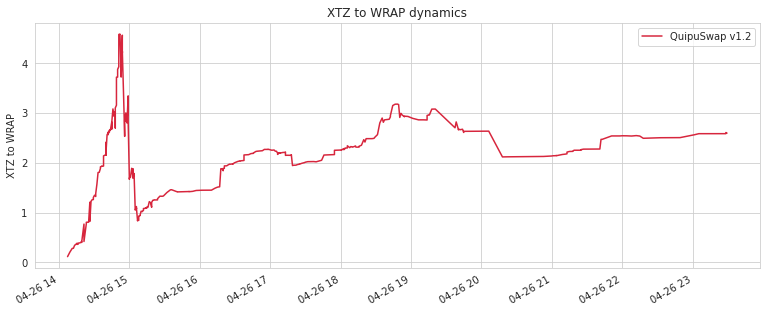

In [3]:
data.rate.rename('QuipuSwap v1.2').plot(color='#D7263D', figsize=(13,5))

plt.xlabel('')
plt.ylabel(f'XTZ to {token}')
plt.legend()
_ = plt.title(f'XTZ to {token} dynamics')

# If you want to save plot, uncomment this line:
# plt.savefig(f'{token}_price_dynamics.png')

### Plotting pools data:

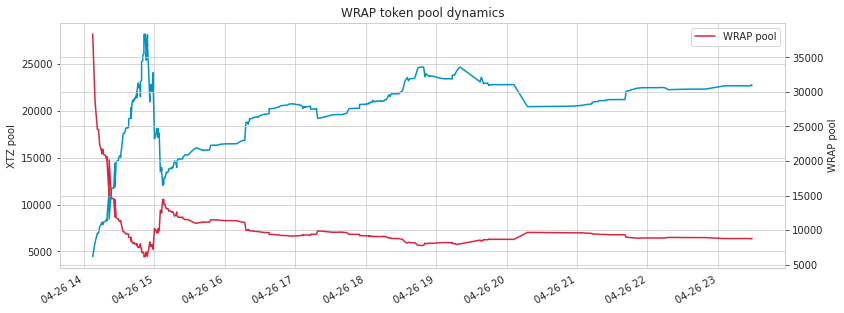

In [4]:
ax1 = data['value.storage.tez_pool'].rename(f'XTZ pool').plot(figsize=(13,5), color='#0094C6')
ax1.set_ylabel('XTZ pool')

ax2 = ax1.twinx()
ax2.set_ylabel(f'{token} pool')

data['value.storage.token_pool'].rename(f'{token} pool').plot(ax=ax2, color='#D7263D')

ax1.set_xlabel("")
plt.legend()
_ = plt.title(f'{token} token pool dynamics')

# If you want to save plot, uncomment this line:
# plt.savefig(f'{token}_pool_dynamics.png')